In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')
    
from tumor_data_processor import * 
from tumor_data_processor_2 import * 
from lengths_data_processor import *

In [3]:
data = pd.read_csv('datasets/P6.Inform/I062.022.WGS.Tumor_events.txt', sep='\t', comment='#')

data

,Chromosome Region,Event,Length,Cytoband,% of CNV Overlap,Probe Median,% Heterozygous,Probes,Count of Gene Symbols
0,"chr1:862,439-1,313,714",CN Gain,451276,p36.33,100.000000,0.254980,NaN,15,35
1,"chr1:2,323,340-2,500,322",CN Gain,176983,p36.32,98.491937,0.372007,NaN,6,8
2,"chr1:9,840,751-10,297,200",CN Loss,456450,p36.22,4.657695,-0.247301,NaN,14,8
3,"chr1:28,313,363-29,454,028",CN Loss,1140666,p35.3,5.721575,-0.252082,NaN,34,25
4,"chr1:32,265,271-32,656,728",CN Loss,391458,p35.2 - p35.1,6.300564,-0.241056,NaN,12,7
...,...,...,...,...,...,...,...,...,...
374,"chrX:153,411,122-153,945,270",High Copy Gain,534149,q28,100.000000,0.746978,NaN,16,37
375,"chrX:153,945,270-154,722,592",CN Gain,777323,q28,100.000000,0.346073,NaN,24,47
376,"chrX:154,722,592-155,270,560",CN Loss,547969,q28,89.647206,-0.355816,NaN,15,8
377,"chrY:3,095,792-7,022,409",CN Loss,3926618,p11.2,10.072309,-0.745243,NaN,12,19


In [4]:
test_data = process_tumor_data(data)

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,451275,862439,1313714
1,1,3,176982,2323340,2500322
2,1,1,456449,9840751,10297200
3,1,1,1140665,28313363,29454028
4,1,1,391457,32265271,32656728
...,...,...,...,...,...
338,22,1,539799,28754409,29294208
339,22,1,423407,31741627,32165034
340,22,3,459941,37448717,37908658
341,22,1,1851735,40438665,42290400


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Chromosome   343 non-null    object
 1   Copy Number  343 non-null    int64 
 2   Length       343 non-null    int64 
 3   Start        343 non-null    int64 
 4   End          343 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 13.5+ KB


In [5]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [6]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [34]:
def check_info_attributes(keys, attributes):
    for attr in attributes:
        if attr not in keys:
            return False
        
    return True

import vcf

vcf_reader_raw = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
vcf_reader = vcf.Reader(filename='datasets/P6.Inform/P13.WES.Discovery.vcf.gz')

In [33]:
count = 0
filtered = 0

for record in vcf_reader_raw: 
    info = record.INFO
    
#     QD>10.0, MQ>40.0, FS<30.0, SOR<3.0, MQRankSum>-12.5 and ReadPOsRankSum>-8.0
    if check_info_attributes(info.keys(), ['QD', 'MQ', 'FS', 'SOR', 'MQRankSum', 'ReadPosRankSum']) and info['QD'] > 10.0 and info['MQ'] > 40.0 and info['FS'] < 30.0 and info['SOR'] < 3.0 and info['MQRankSum'] > -12.5 and info['ReadPosRankSum'] > -8.0:
        filtered += 1

    count += 1 
    
print((filtered / count) * 100)
print(count)
print(filtered)

59.83167559296098
23526
14076


In [ ]:
quals = np.array([])

for record in vcf_reader_raw: 
    if 'MQRankSum' not in record.INFO.keys():
        quals = np.append(quals, record.QUAL)

print(np.mean(quals))

In [62]:
allele_freqs = np.array([])

for record in vcf_reader_raw: 
    if 'MQRankSum' not in record.INFO.keys():
        tumor_I062_007 = record.samples[2]
        
        if tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':

            if tumor_I062_007['AD'][1] == 0:
                allele_freq = 0
            else:
                allele_freq = tumor_I062_007['AD'][1] / (tumor_I062_007['AD'][0] + tumor_I062_007['AD'][1])
                
            allele_freqs = np.append(allele_freqs, allele_freq)

print(np.median(allele_freqs))
print(np.mean(allele_freqs))

[1, 307]
[42, 51]
1.0
0.99954311191951


In [9]:
depths = np.array([])

for record in vcf_reader_raw: 
    if 'MQRankSum' not in record.INFO.keys():
        tumor_I062_007 = record.samples[2]
        
        if tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':
            depths = np.append(depths, tumor_I062_007['DP'])
                
print(np.mean(depths))

113.65233575283827


In [10]:
Mb = 1000000
S_small = 3 * Mb
LST_SMb = 10 * Mb

In [9]:
def insert_row(df, _chr, cn, length, start, end, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


def fill_segments(data):
    df = data.copy()
    index_df = 0

    for index, row in data.iterrows():

        # first cnv region in chromosome
        if index == 0 or data.loc[index-1, 'Chromosome'] != data.loc[index, 'Chromosome']:
            if row['Start'] != 0:
                df = insert_row(df, row['Chromosome'], 2, row['Start'], 0, row['Start'], index_df)
                index_df += 1

        # not first cnv region in chromosome 
        elif data.loc[index-1, 'End'] != data.loc[index, 'Start']:
            prev = data.loc[index-1]

            df = insert_row(df, row['Chromosome'], 2, row['Start'] - prev['End'], prev['End'], row['Start'], index_df)
            index_df += 1

        # last cnv region in chromosome
        if index == len(data) - 1 or data.loc[index+1, 'Chromosome'] != data.loc[index, 'Chromosome']:

            chr_len = lengths.loc[row['Chromosome'], 'Length']
            if row['End'] != chr_len:      
                df = insert_row(df, row['Chromosome'], 2, chr_len - row['End'], row['End'], chr_len, index_df+1)
                index_df += 1

        index_df += 1

    return df

In [8]:
pd.set_option('display.max_rows', 1000)

In [45]:
filled_data = fill_segments(test_data)

filled_data

,Chromosome,Copy Number,Length,Start,End
0,1,2,862439,0,862439
1,1,3,451275,862439,1313714
2,1,2,1009626,1313714,2323340
3,1,3,176982,2323340,2500322
4,1,2,7340429,2500322,9840751
5,1,1,456449,9840751,10297200
6,1,2,18016163,10297200,28313363
7,1,1,1140665,28313363,29454028
8,1,2,2811243,29454028,32265271
9,1,1,391457,32265271,32656728


In [47]:
def has_quality(record):
    info = record.INFO
    return check_info_attributes(info.keys(), ['QD', 'MQ', 'FS', 'SOR', 'MQRankSum', 'ReadPosRankSum']) and info['QD'] > 10.0 and info['MQ'] > 40.0 and info['FS'] < 30.0 \
        and info['SOR'] < 3.0 and info['MQRankSum'] > -12.5 and info['ReadPosRankSum'] > -8.0

filled_variants_data = filled_data.copy()
filled_variants_data['Variants Count'] = 0

for index, row in filled_variants_data.iterrows():
    
    count = 0
    for record in vcf_reader_raw.fetch(row['Chromosome'], row['Start'], row['End']):
        tumor_I062_007 = record.samples[2]
        
        if has_quality(record) and tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':
            count += 1
            
        filled_variants_data.loc[index, 'Variants Count'] = count
        
filled_variants_data

,Chromosome,Copy Number,Length,Start,End,Variants Count
0,1,2,862439,0,862439,0
1,1,3,451275,862439,1313714,16
2,1,2,1009626,1313714,2323340,20
3,1,3,176982,2323340,2500322,9
4,1,2,7340429,2500322,9840751,62
5,1,1,456449,9840751,10297200,0
6,1,2,18016163,10297200,28313363,222
7,1,1,1140665,28313363,29454028,8
8,1,2,2811243,29454028,32265271,13
9,1,1,391457,32265271,32656728,0


In [97]:
chromosome_names = [str(_chr) for _chr in range(1, 23)]

def plot_chromosomes_variant_count(data):
    fig,axs = plt.subplots(nrows=11, ncols=2, figsize=(15, 40), constrained_layout=True)
    max_count = data['Variants Count'].max()

    for index, name in enumerate(chromosome_names):
        chr_data = data[data['Chromosome'] == name]
        chr_data = chr_data.reset_index(drop=True)

        ax = axs[index // 2, index % 2]
        ax.set_ylim([0, max_count + 10])
        ax.set_title('Variant counts - chromosome ' + name, fontdict={'fontsize': 16})
        ax.bar(chr_data.index, chr_data['Variants Count'])

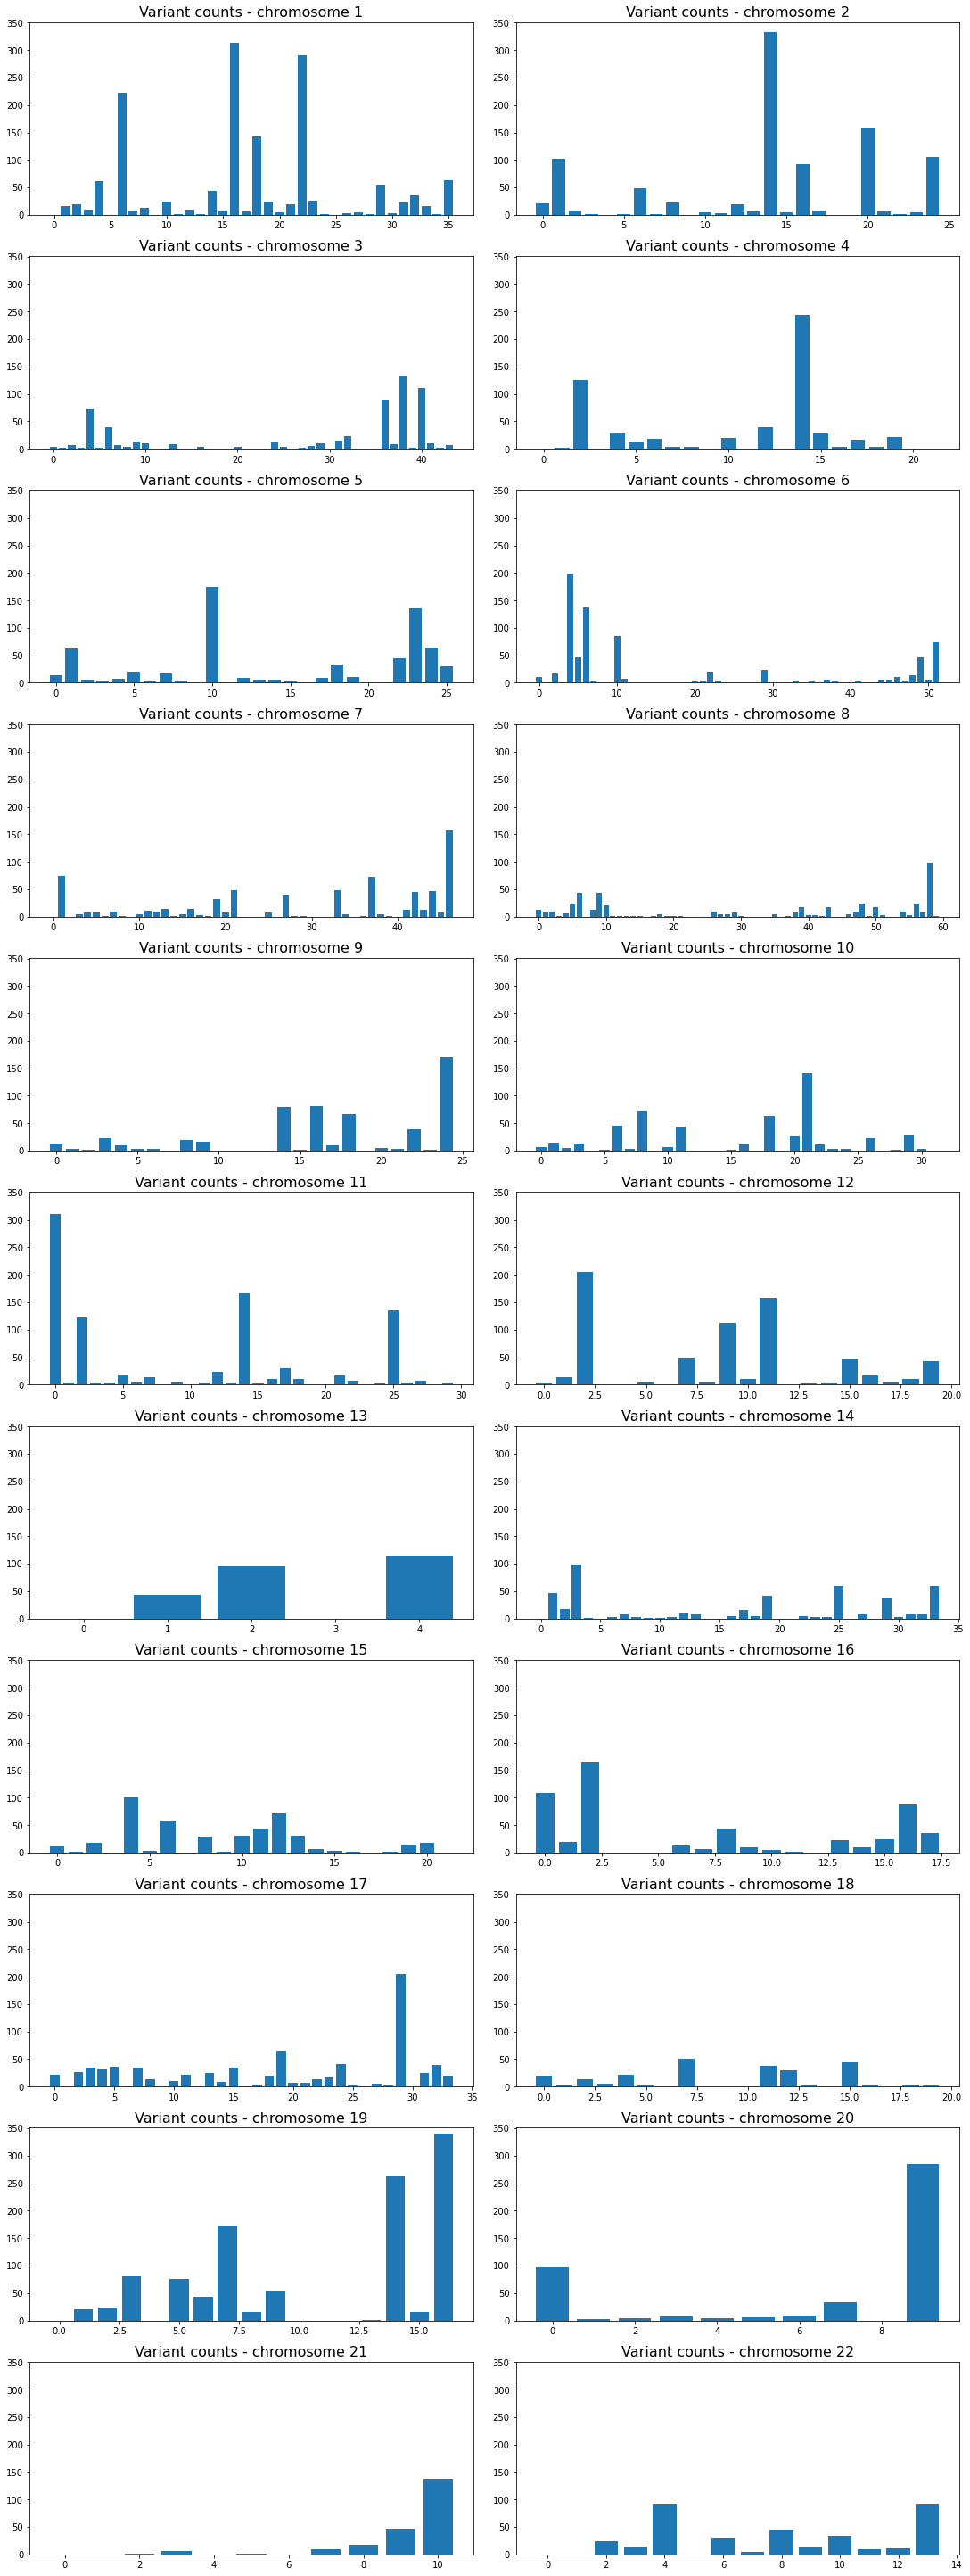

In [98]:
plot_chromosomes_variant_count(filled_variants_data)

In [90]:
def plot_genome_variant_counts(data):
    max_count = data['Variants Count'].max()
    yticks = [i for i in range(0, max_count + 10, 10)]

    plt.figure(figsize=(20, 10))
    plt.yticks(ticks=yticks)
    plt.title('Variant counts', fontdict={'fontsize': 16})
    plt.bar(data.index, data['Variants Count'])

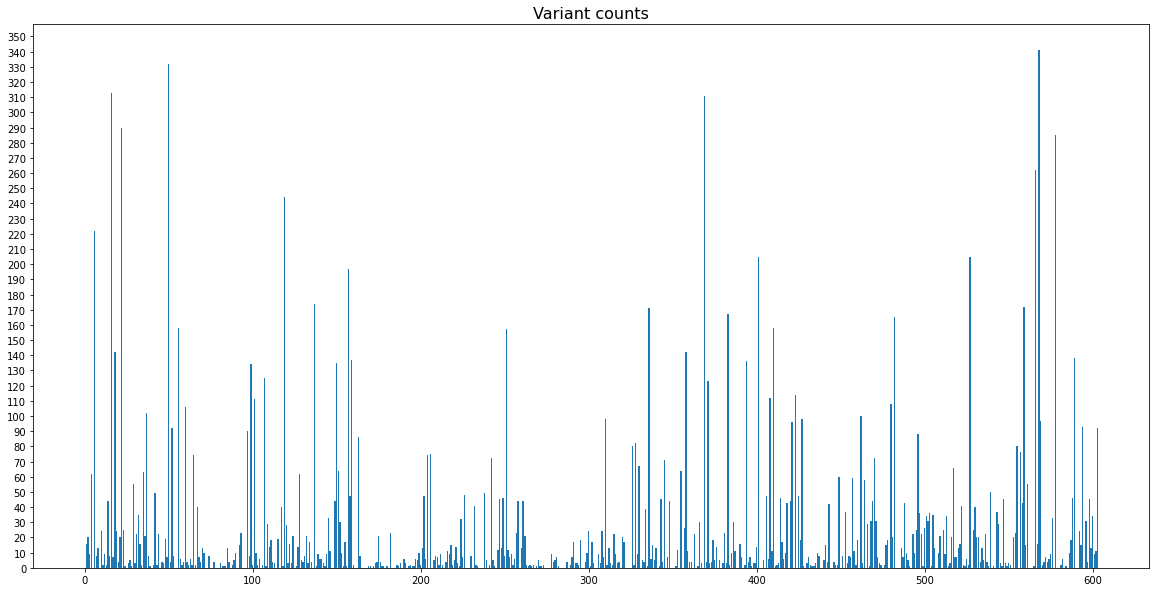

In [91]:
plot_genome_variant_counts(filled_variants_data)

In [85]:
def has_quality_2(record):
    info = record.INFO
    return ('QD' not in info.keys() or info['QD'] > 10.0) and ('MQ' not in info.keys() or info['MQ'] > 40.0) \
        and ('FS' not in info.keys() or info['FS'] < 30.0 ) and ('SOR' not in info.keys() or info['SOR'] < 3.0) \
        and ('MQRankSuminfo' not in info.keys() or ['MQRankSum'] > -12.5) and ('ReadPosRankSum' not in info.keys() or info['ReadPosRankSum'] > -8.0)

filled_variants_data_2 = filled_data.copy()
filled_variants_data_2['Variants Count'] = 0

for index, row in filled_variants_data_2.iterrows():
    
    count = 0
    for record in vcf_reader_raw.fetch(row['Chromosome'], row['Start'], row['End']):
        tumor_I062_007 = record.samples[2]
        
        if has_quality_2(record) and tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':
            count += 1
            
        filled_variants_data_2.loc[index, 'Variants Count'] = count
        
filled_variants_data_2

,Chromosome,Copy Number,Length,Start,End,Variants Count
0,1,2,862439,0,862439,0
1,1,3,451275,862439,1313714,29
2,1,2,1009626,1313714,2323340,22
3,1,3,176982,2323340,2500322,10
4,1,2,7340429,2500322,9840751,84
5,1,1,456449,9840751,10297200,0
6,1,2,18016163,10297200,28313363,307
7,1,1,1140665,28313363,29454028,8
8,1,2,2811243,29454028,32265271,18
9,1,1,391457,32265271,32656728,2


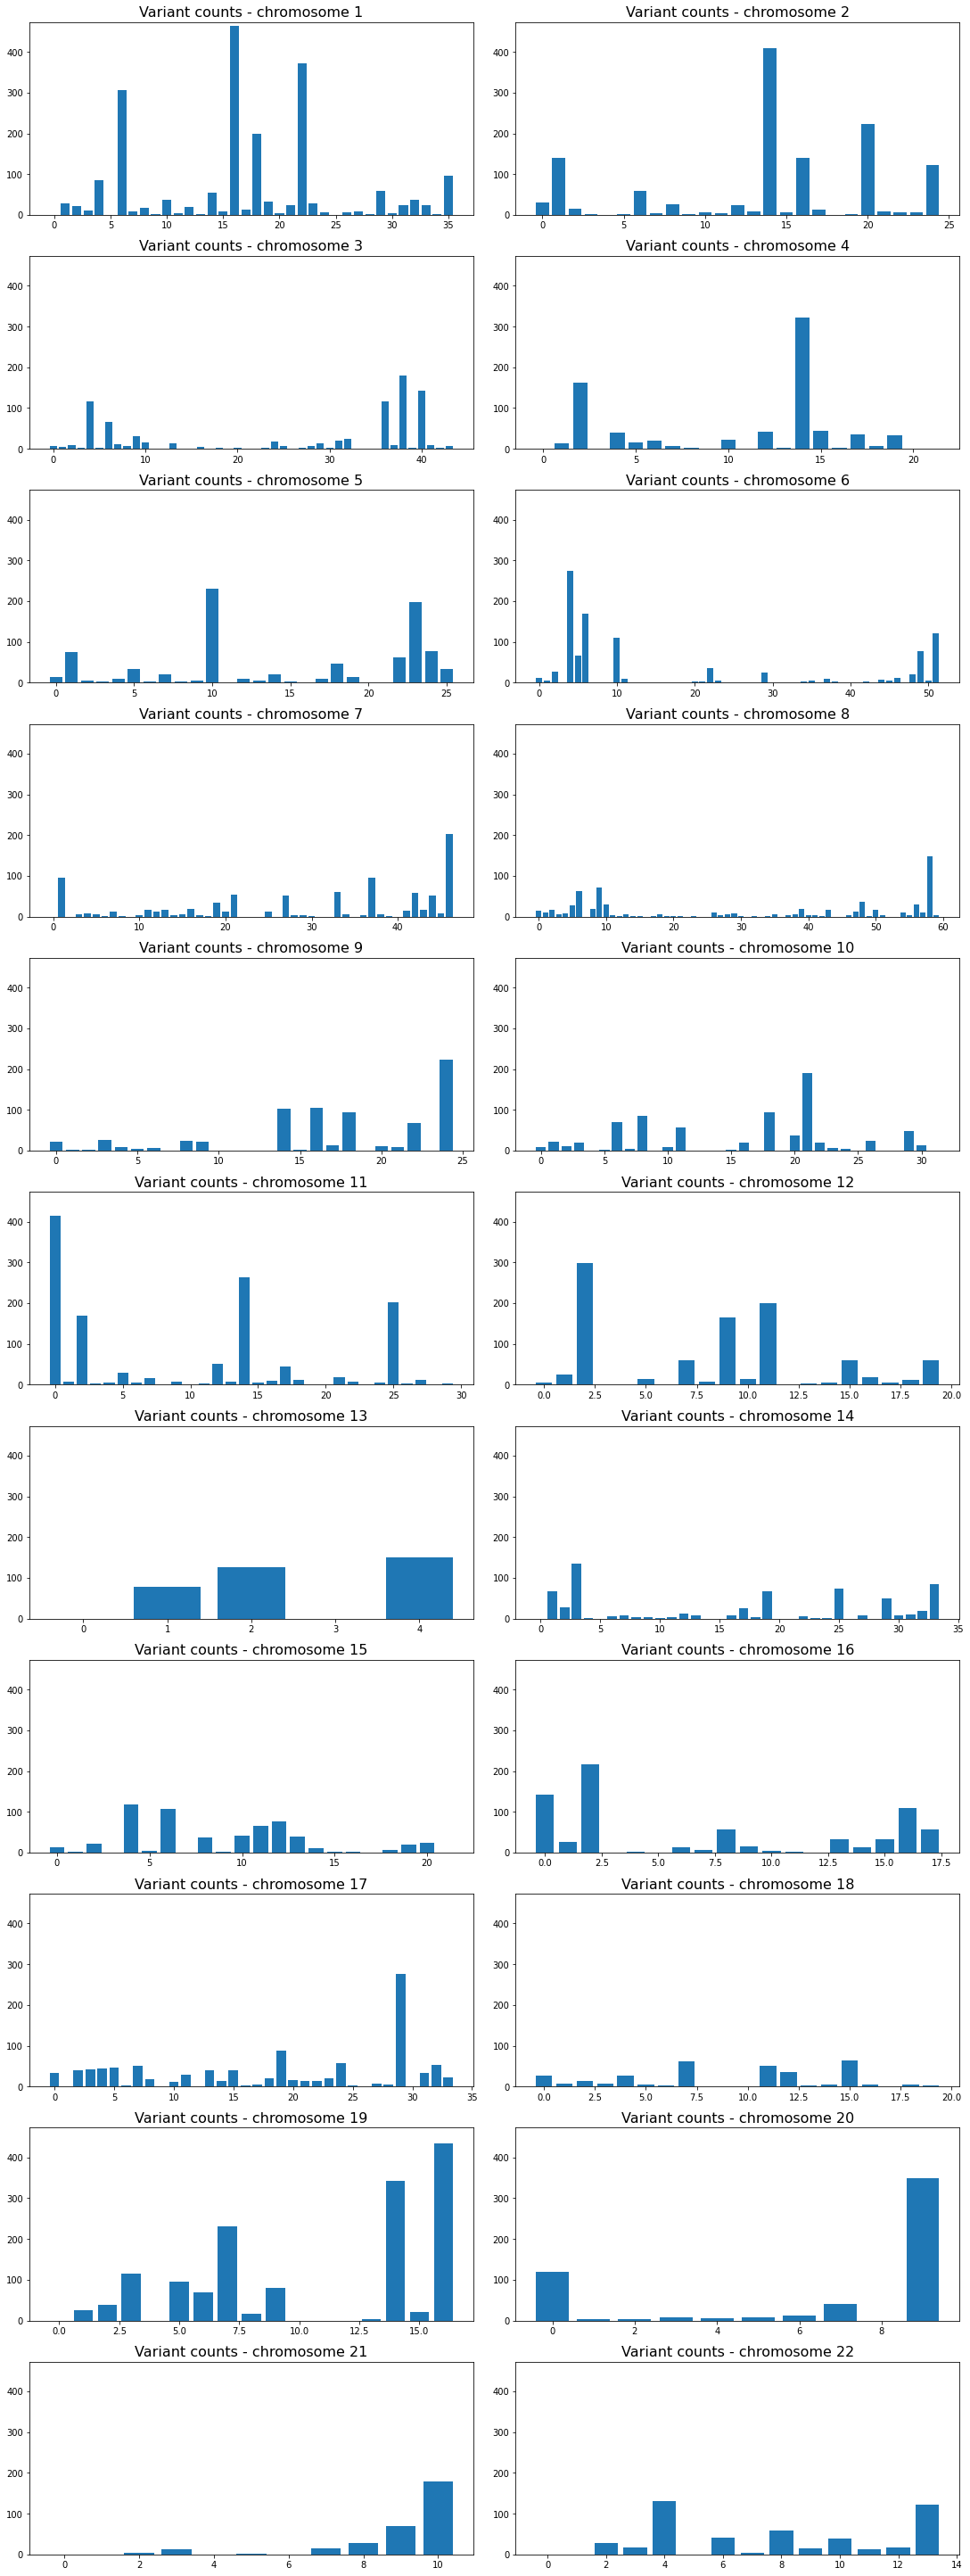

In [99]:
plot_chromosomes_variant_count(filled_variants_data_2)

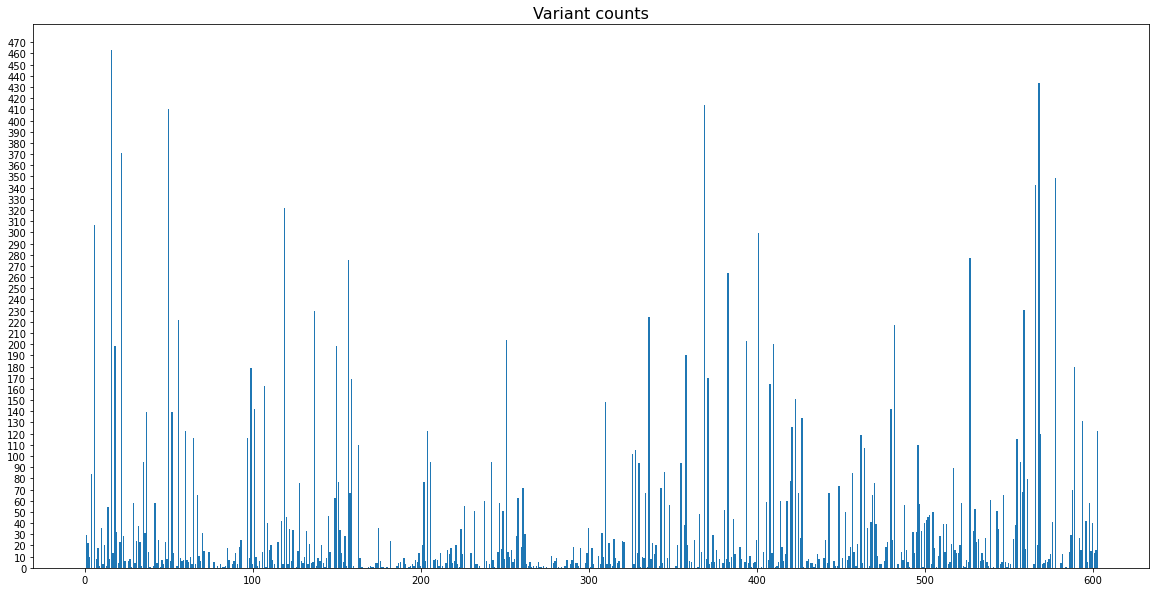

In [100]:
plot_genome_variant_counts(filled_variants_data_2)

In [12]:
def link_segments(df, prev, _next):
    df = df.drop(index=prev.name)
    df = df.drop(index=_next.name)
    df = insert_row(df, prev['Chromosome'], prev['Copy Number'],  _next['End'] - prev['Start'],  prev['Start'], _next['End'], prev.name)
    
    return df
    

def coercing(data):
    df2 = data.copy()

    while True:

        # get smallest segment
        row = df2[df2['Length'] == df2['Length'].min()].iloc[0]
        index = row.name

        # filter out?
        if row['Length'] < S_small:

            # not first or last segment of profile?
            if index != 0 and index != len(df2) - 1:
                prev = df2.loc[ index-1 ]
                _next = df2.loc[ index+1 ]

                # can link?
                if prev['Chromosome'] == _next['Chromosome'] == row['Chromosome'] and prev['Copy Number'] == _next['Copy Number']:
                    df2 = link_segments(df2, prev, _next)

            # delete small segment
            df2 = df2.drop(index=index).reset_index(drop=True)

        # if there are no small segments left -> end
        else:
            return df2

In [13]:
coerce_data = coercing(filled_data)

coerce_data

,Chromosome,Copy Number,Length,Start,End
0,1,2,159064820,0,159064820
1,1,3,4098498,159064820,163163318
2,1,2,56332475,163163318,219495793
3,1,3,29754828,219495793,249250621
4,2,2,10805837,0,10805837
5,2,3,21411345,10805837,32217182
6,2,2,210982191,32217182,243199373
7,3,1,54106210,0,54106210
8,3,2,5846600,54106210,59952810
9,3,3,15846561,59952810,75799371


In [18]:
# this method of coercing doesn't exclude small segments while coercing instead remove all small segments at the end of method
def coercing2(data):
    df2 = data.copy()
    df2['checked'] = 0

    while True:

        # get smallest segment
        not_checked = df2[df2['checked'] != 1]
        row = df2[df2['Length'] == not_checked['Length'].min()].iloc[0]
        index = row.name

        # filter out?
        if row['Length'] < S_small:

            df2.loc[index, 'checked'] = 1
            
            # not first or last segment of profile?
            if index != 0 and index != len(df2) - 1:
                prev = df2.loc[ index-1 ]
                _next = df2.loc[ index+1 ]

                # can link?
                if prev['Chromosome'] == _next['Chromosome'] == row['Chromosome'] and prev['Copy Number'] == _next['Copy Number']:
                    df2 = link_segments(df2, prev, _next)
                    
                    # delete small segment
                    df2 = df2.drop(index=index).reset_index(drop=True)

        # if there are no small segments left -> end
        else:
            df2 = df2[df2['checked'] != 1]
            df2 = df2.drop(columns='checked').reset_index(drop=True)
            return df2

In [14]:
lsts = 0

for index, row in coerce_data.iterrows():
    
    # not last segment in profile?
    if index != len(coerce_data) - 1:
        
        _next = coerce_data.loc[index+1]
        if row['Length'] >= LST_SMb and _next['Length'] >= LST_SMb and _next['Chromosome'] == row['Chromosome'] and _next['Start'] - row['End'] < S_small:
            lsts += 1
            
print(lsts)

29


In [15]:
def lst(data):
    pass